1789.1718334292052


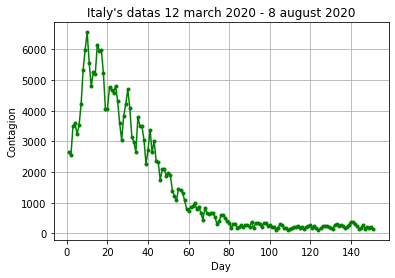

In [190]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy
from scipy.stats import poisson
import statistics






import matplotlib.pyplot as plt
import math
import numpy as np
import scipy
from scipy.stats import poisson
import statistics






x=[]
y=[]


#leggo i dati 
for line in open('prova.txt', 'r'):
    lines = [i for i in line.split()]
    x.append(int(lines[1]))
    y.append(int(lines[0]))
    
for i in range(0,151):
    x[i]=x[i]-17

std=statistics.stdev(y)
print(std)
#plot dei nuovi positivi nel periodo considerato
plt.title("Italy's datas 12 march 2020 - 8 august 2020")
plt.xlabel('Day')
plt.ylabel('Contagion')
plt.plot(x, y, marker = '.', c = 'g')
plt.grid()
plt.show()

In [191]:
def Gomp(i,K,r,x0):
    c=np.log(1./K)
    g=K*np.exp(c*np.exp(-r*np.array(x[i]-x0)))
    return g


#differenze finite Gompertz
def diff_Gomp(i,K,r,x0):
    h = Gomp(x[i+1],K,r,x0)-Gomp(x[i],K,r,x0)
    return h

In [192]:
#definisco la funzione che calcola la log-likelihood 
def likelihood(x,y,theta):
    K, r, x0 = theta

    l=[None]*150
    z=[None]*150
    #poisson.pmf(k,m) 
    for i in range(0,150):
        z[i]=poisson.pmf(y[i],diff_Gomp(x[i],K,r,x0))
        l[i]=np.log(z[i])
    return np.nansum(l)



In [193]:
#definisco log prior e log pos
def log_prior(theta):
    K, r, x0 = theta
    if x0 < 0. and r >0. and K>0.:
        return 0.0
    return -np.inf


def log_pos(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + likelihood(x,y,theta)

theta = [100000., 0.05 , -15]

print(log_prior(theta))
print(log_pos(theta,x,y))

0.0


C:\Users\marco\AppData\Local\Temp\ipykernel_26728\281823555.py:10: RuntimeWarning: divide by zero encountered in log
  l[i]=np.log(z[i])


IndexError: list index out of range